# K-Means Clustering of a Large Electroencephalography Dataset

### Kiron Ang, September 2024

---

## INTRODUCTION

The use of machine learning to analyze and process electroencephalogram (EEG) data has received greater interest in the years since the COVID-19 pandemic, partially because of its potential in the field of medical devices [1]. EEG data consists of signals captured by sensors in an attempt to monitor brain activity. It is clear that the signals captured vary based on external stimuli that subjects receive, leading to the idea of neural correlates based on various factors, such as perception [2]. Although the topic of perception requires a discussion of factors other than simply EEG data [3], the current advances in machine learning and the rise of access in machine learning methods warrants a new presentation of a potential way to analyze EEG data.

A major impetus for the present work is the release of a dataset over 50 GB in size by David Vivancos [4]. His accompanying preprint work [5] describes how, in June 2023, he publicly released the data he collected from himself while observing 70,000 images of handwritten digits from the 1998 MNIST dataset. Here, I present a Google Colab analysis of a 7 GB portion of the data that Vivancos produced. After preprocessing and dimensionality reduction, I use a k-means clustering algorithm to determine whether or not there are patterns intrinsic to the data that may reflect the numbers observed while the data was collected.


## METHODS & RESULTS

This entire analysis was carried out with the Python programming language in Google Colab, a free online platform that enables users to utilize computational resources for a variety of projects, including those related to machine learning and data analysis. In an effort to increase accessibility to this kind of work, this section details all code used to generated results. The cell immediately below this showcases the Python libraries used.

In [ ]:
# Print out Python version.
!python -V

# Update/install prerequisite libraries.
!pip install -U polars
!pip install -U scikit-learn
!pip install -U matplotlib

Data was downloaded from https://huggingface.co/datasets/DavidVivancos/MindBigData2023_MNIST-8B. The 7 GB "test.csv" file was first downloaded to a local machine and then uploaded to a personal Google Drive. Below, I give access to Google Colab to mount a personal Google Drive.

In [ ]:
import google
google.colab.drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


The *polars* library was used to store data in its efficient LazyFrames and DataFrames, two tabular data structures. LazyFrames are critical for this analysis because through them, *polars* performs lazy evaluation and notably reduces System RAM usage. This is a significant benefit because System RAM is limited for free users of Google Colab.

In [ ]:
import polars
# Read the data from a personal Google Drive file.
data = polars.scan_csv("/content/drive/My Drive/data.csv")
print("data:", data)

data: naive plan: (run LazyFrame.explain(optimized=True) to see the optimized plan)

Csv SCAN [/content/drive/My Drive/data.csv]
PROJECT */64791 COLUMNS


As shown above, the data consists of 64,791 columns. To prevent negative effects from the "Curse of Dimensionality", the next several cells of code focus on reducing the number of features. The first attempt is to subset the features intended for use as input into the k-means clustering algorithm. Vivancos states that the first 64,000 columns contain the raw EEG data in numeric form, where each integer represents microvolts collected from a particular section of the brain. Each of those 64,000 columns are named  based on the location of the brain that the sensor targeted and the receiving signal channel.

In [ ]:
# Get the names of the first 64,000 columns.
X = data.select(data.collect_schema().names()[0:64000])
print("X:", X)

Because of the LazyFrame's lazy evaluation, the data is not actually subset yet until computation is explicitly required. Before doing so, the columns' data types were checked to confirm that they were numeric.

In [ ]:
dtypes = X.collect_schema().dtypes()
print("dtypes:", dtypes)

Below is code that iterates over the "dtypes" list to check whether any of the columns contain something other than integers.

In [ ]:
# Iterate over ever data type and compare
# to make sure that it is Int64.
dtype_int = 0
dtype_not_int = 0
for dtype in dtypes:
  if str(dtype) == "Int64":
    dtype_int += 1
  else:
    dtype_not_int += 1
print("Number of Int64 columns:", dtype_int)
print("Number of columns that are NOT Int64:", dtype_not_int)

Number of Int64 columns: 64000
Number of columns that are NOT Int64: 0


Now that it is confirmed that all columns are numeric, this opens the path for further feature selection and extraction. Columns will first be selected based on variance and then principle component analysis will be performed to transform the data and extract a considerably smaller amount of features with which to cluster the data. Below, each of the subset 64,000 columns are aggregated by the variance of their data values.

In [ ]:
# Call .collect() at the end to convert the result to a DataFrame.
# This prevents lazy evaluation but allows for actual computation.
var = X.var().collect()
print("var:", var)

var: shape: (1, 64_000)
┌──────────┬──────────┬──────────┬──────────┬───┬──────────┬──────────┬──────────┬──────────┐
│ FP1_0    ┆ FP1_1    ┆ FP1_2    ┆ FP1_3    ┆ … ┆ I2_496   ┆ I2_497   ┆ I2_498   ┆ I2_499   │
│ ---      ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
│ f64      ┆ f64      ┆ f64      ┆ f64      ┆   ┆ f64      ┆ f64      ┆ f64      ┆ f64      │
╞══════════╪══════════╪══════════╪══════════╪═══╪══════════╪══════════╪══════════╪══════════╡
│ 2.4504e8 ┆ 2.5082e8 ┆ 2.4936e8 ┆ 2.4835e8 ┆ … ┆ 1.9458e8 ┆ 1.9877e8 ┆ 2.0167e8 ┆ 2.0008e8 │
└──────────┴──────────┴──────────┴──────────┴───┴──────────┴──────────┴──────────┴──────────┘


The variance values were then extracted from the first row of the DataFrame produced and a histogram of these values was generated with the library *matplotlib*.

(array([5.611e+04, 6.391e+03, 4.990e+02, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 4.400e+01, 4.650e+02, 4.910e+02]),
 array([1.02560964e+08, 5.08958877e+08, 9.15356789e+08, 1.32175470e+09,
        1.72815261e+09, 2.13455053e+09, 2.54094844e+09, 2.94734635e+09,
        3.35374426e+09, 3.76014218e+09, 4.16654009e+09]),
 <BarContainer object of 10 artists>)

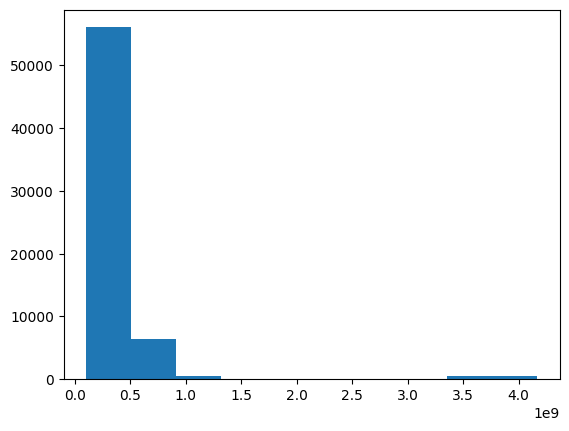

In [ ]:
# Obtain an array and use it to generate a histogram.
var = var.row(0)
import matplotlib
matplotlib.pyplot.hist(var)

The histogram above demonstrates that there are two distinct groups of columns in the data, with one group having much higher variance than the other. The Google Colab resources on the free tier are extremely limited for big data analysis, with the earlier variance calculation nearly exhausting the 12 GB of System RAM available and disconnecting the runtime, and therefore only columns with a high amount of variance were kept for the remainder of this analysis. An arbitrary threshold was decided on by obtaining the maximum variance value and dividing by ten. There is no particular precedent in EEG data for this kind of varianc-based selection, and so a simple adaptive threshold is used here because it can be applied later on to other datasets in a reproducible manner.

In [ ]:
# Calculate a variance threshold. Iterate through the list of column
# names and only append names that match columns with a high enough variance.
names = X.collect_schema().names()
number = 0
columns_to_keep = []
variance_threshold = max(var) / 10
print("variance threshold:", variance_threshold)
for value in var:
  if value > variance_threshold:
    columns_to_keep.append(names[number])
  number += 1
print("length of columns_to_keep:", len(columns_to_keep))

variance threshold: 416654008.8650125
length of columns_to_keep: 17642


17,642 columns were kept after this selection. To reduce this number further to avoid the "Curse of Dimensionality", principle component analysis was performed using *scikit-learn*. Because some of the columns had a large variance relative to the others, there may be extreme outliers in the data; the RobustScaler was used before PCA to prevent the negative effect of outliers. Furthermore, data on the other axis was filtered out. Some of the observations were collected by Vivancos as "blanks", data collected during buffer time in between images. He did this to avoid bias in the data from previous images he viewed on the screen. Although these values are useful for determining variance because they present a baseline value that may mitigate the effect of outliers, they are not practical for use in the final analysis because they are not meaningful observations. The data now consists of 17,642 columns and 10,000 rows.

In [ ]:
# Select the 17,642 columns specified earlier and gather every other row.
# Every other row is a blank.
X = X.select(columns_to_keep).gather_every(2, offset=1).collect()
import sklearn.preprocessing
# Transform the DataFrame "X" with the RobustScaler's default parameters.
X = sklearn.preprocessing.RobustScaler().fit_transform(X)
print("X:", X)

X: [[ 0.79051704  0.23816922 -0.95500469 ... -0.61578402 -1.11317566
   0.16107688]
 [ 0.62680892  0.68822314  1.02150163 ... -0.19039437 -1.33950788
  -1.3746817 ]
 [ 0.50927211  0.13017968 -0.22954129 ... -0.19883642 -0.00611089
  -1.22666818]
 ...
 [-0.05631747 -0.71308194 -1.08714101 ...  0.4907595   1.42353267
   1.49316067]
 [ 0.4184433   0.50620556  0.25780517 ...  0.37996694  0.23851582
  -0.61378847]
 [-0.61945611 -1.84942148 -1.15360222 ...  0.8587731   0.7959057
   0.60148241]]


Principle component analysis (PCA) was first performed with the default settings in *scikit-learn* to determine how many principle components to keep.

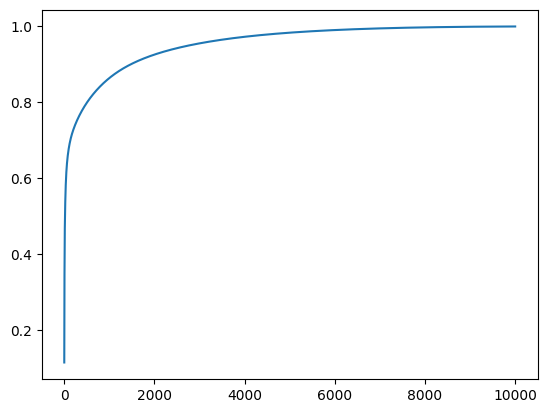

In [ ]:
import sklearn.decomposition
pca = sklearn.decomposition.PCA().fit(X)
# Create a plot with the cumulative summation of the explained variance ratios.
# The ratios are ordered from highest explained variance to lowest explained variance.
matplotlib.pyplot.plot(pca.explained_variance_ratio_.cumsum())

The plot above demonstrates that even without all of the principle components, a large amount of the variance within the data can be explained. Below is code to determine the appropriate number of components to use moving forward by stopping once 90% explained variance has been reached. Furthermore, the labels needed to evaluate the work of the k-means clustering later on are subset now.


In [ ]:
# Make sure to use gather_every again to remove the blanks!
y = data.select("label").gather_every(2, offset=1).collect()
print("y:", y)
n_unique = y.n_unique()
print("n_unique:", n_unique)

# "ratios" is an array. Iterate through it and then increment "counter"
# to keep track of where the 90% mark was reached.
counter = 0
ratios = pca.explained_variance_ratio_.cumsum()
for ratio in ratios:
  if ratio > .90:
    print(f"{ratio} explained variance ratio with {counter} components!")
    break
  counter += 1

y: shape: (10_000, 1)
┌───────┐
│ label │
│ ---   │
│ i64   │
╞═══════╡
│ 7     │
│ 2     │
│ 1     │
│ 0     │
│ 4     │
│ …     │
│ 2     │
│ 3     │
│ 4     │
│ 5     │
│ 6     │
└───────┘
n_unique: 10
0.9000130842968745 explained variance ratio with 1471 components!


PCA was performed again with the minimum number of components required to explain at least 90% of the variance. The data was transformed along the components and then fed into *scikit-learn*'s k-means clustering algorithm. The number of clusters is equivalent to the number of unique labels, which is ten. However, it is unclear at first whether the clusters predicted represent gruops that consist of mainly one "ground truth" label.

In [ ]:
# Transform the input features and feed them into the k-means clustering
# algorithm. Note that earlier, only "fit()" was called on the PCA instance.
X = sklearn.decomposition.PCA(n_components=counter).fit_transform(X)
import sklearn.cluster
predictions = sklearn.cluster.KMeans(n_clusters=n_unique).fit_predict(X)
print("predictions:", predictions)

predictions: [8 8 4 ... 4 7 7]


The number of occurences of each label and prediction were counted; the counts are shown below.

In [ ]:
# Create some data structures to hold labels and predictions.
labels = y.rows()
labels = [label[0] for label in labels]
labels_set = [label for label in set(labels)]
labels_set.sort()
print("labels_set:", labels_set)
predictions_set = list(set(predictions))
print("predictions_set:", predictions_set)
labels_dictionary = {}
predictions_dictionary = {}

# Populate the dictionaries through iteration
# to avoid "hard-coding".
for label in labels:
  if label in labels_dictionary:
    labels_dictionary[label] += 1
  else:
    labels_dictionary[label] = 1

for prediction in predictions:
  if prediction in predictions_dictionary:
    predictions_dictionary[prediction] += 1
  else:
    predictions_dictionary[prediction] = 1

# Sort the dictionaries and print them out!
labels_dictionary = dict(sorted(labels_dictionary.items()))
predictions_dictionary = dict(sorted(predictions_dictionary.items()))
print("labels_dictionary:", labels_dictionary)
print("predictions_dictionary:", predictions_dictionary)

labels_set: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
predictions_set: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
labels_dictionary: {0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}
predictions_dictionary: {0: 65, 1: 216, 2: 266, 3: 2192, 4: 2153, 5: 258, 6: 289, 7: 2120, 8: 2234, 9: 207}


The true labels themselves had a relatively even distributionof data points compared to the predicted groups. To clarify which of the prediction clusters may line up with the appropriate labels, bar charts were created to count the number of rows labeled the same in each predicted cluster.

BAR PLOT FOR PREDICTION CLUSTER: 0
TOTAL POINTS IN THE CLUSTER: 65


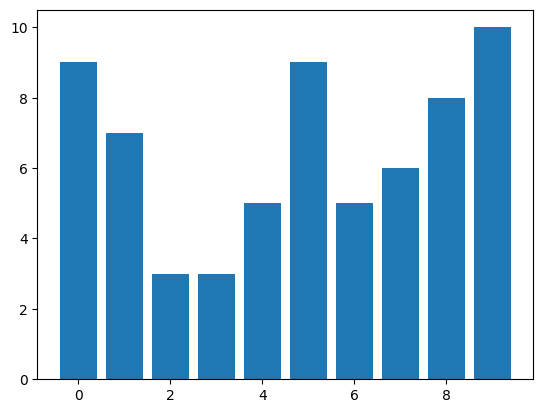

BAR PLOT FOR PREDICTION CLUSTER: 1
TOTAL POINTS IN THE CLUSTER: 216


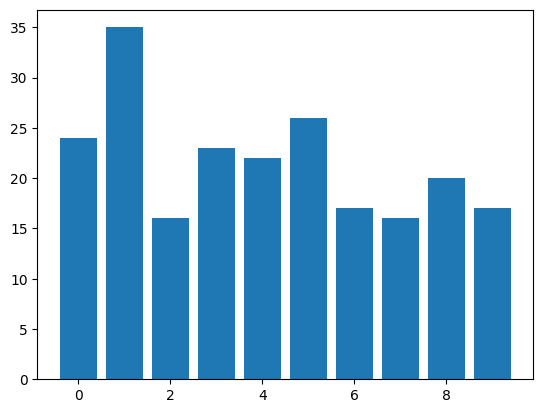

BAR PLOT FOR PREDICTION CLUSTER: 2
TOTAL POINTS IN THE CLUSTER: 266


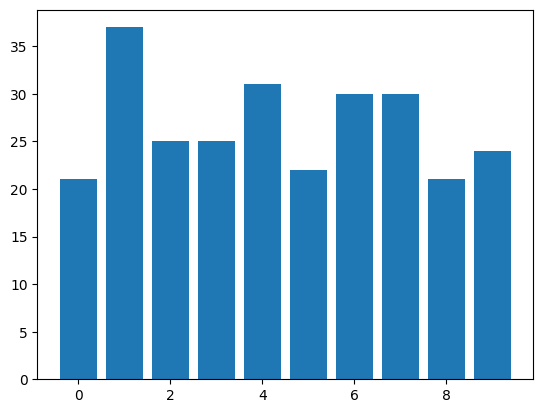

BAR PLOT FOR PREDICTION CLUSTER: 3
TOTAL POINTS IN THE CLUSTER: 2192


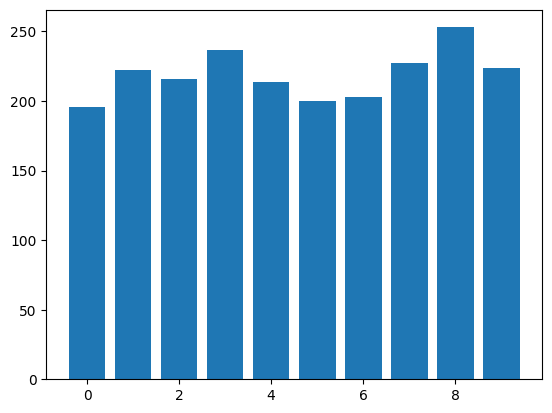

BAR PLOT FOR PREDICTION CLUSTER: 4
TOTAL POINTS IN THE CLUSTER: 2153


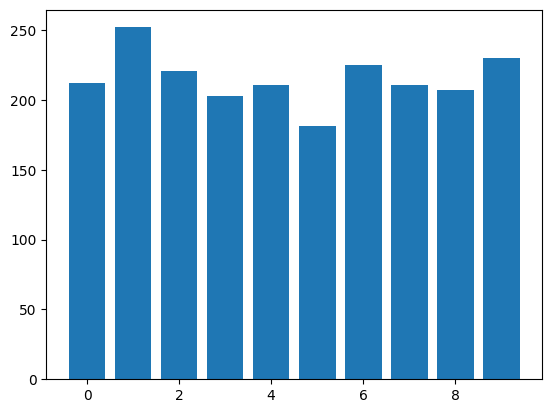

BAR PLOT FOR PREDICTION CLUSTER: 5
TOTAL POINTS IN THE CLUSTER: 258


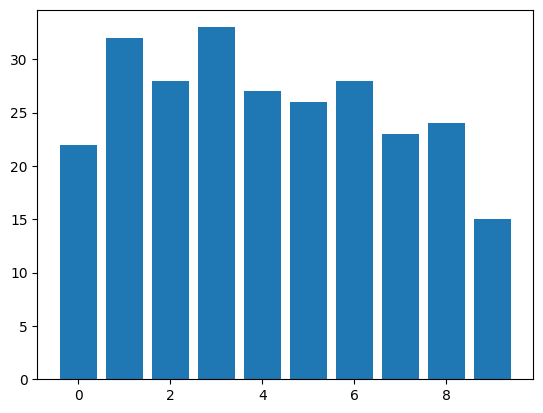

BAR PLOT FOR PREDICTION CLUSTER: 6
TOTAL POINTS IN THE CLUSTER: 289


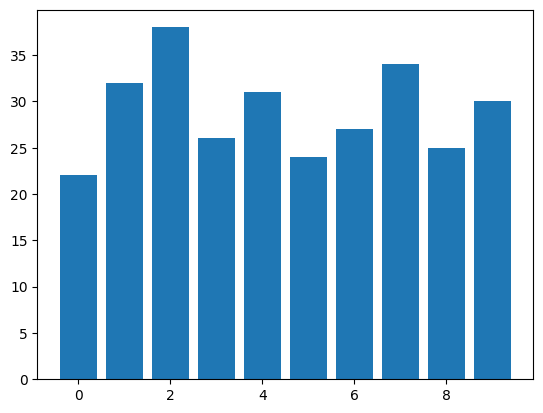

BAR PLOT FOR PREDICTION CLUSTER: 7
TOTAL POINTS IN THE CLUSTER: 2120


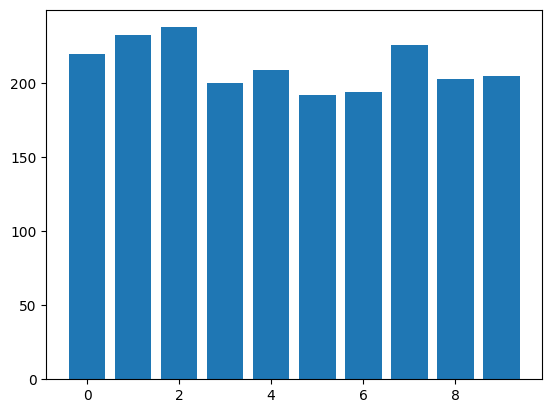

BAR PLOT FOR PREDICTION CLUSTER: 8
TOTAL POINTS IN THE CLUSTER: 2234


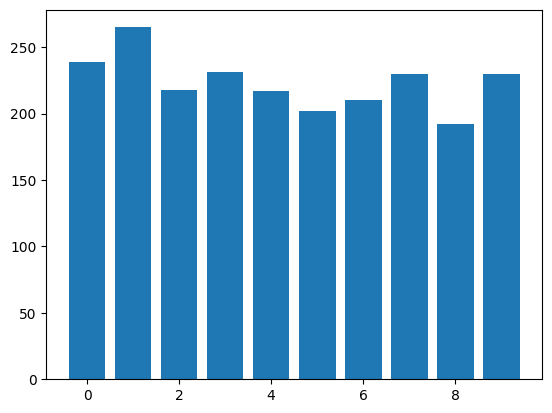

BAR PLOT FOR PREDICTION CLUSTER: 9
TOTAL POINTS IN THE CLUSTER: 207


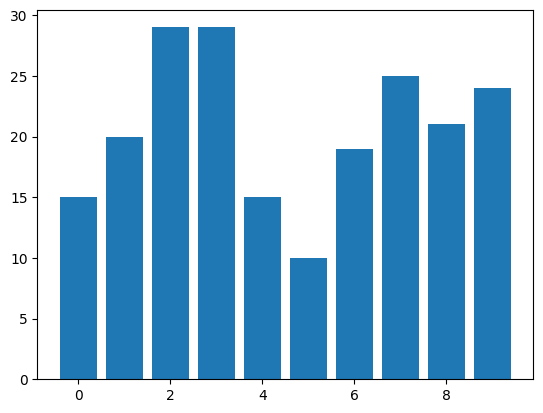

In [ ]:
# Create bar charts by iterating over all the predictions,
# storing the counts in a dictionary, and then plotting
# the dictionary data before moving on.
for cluster in predictions_set:
  label_counter = 0
  labels_dictionary = {}
  for prediction in predictions:
    if prediction == cluster:
      if labels[label_counter] in labels_dictionary:
        labels_dictionary[labels[label_counter]] += 1
      else:
        labels_dictionary[labels[label_counter]] = 1
    label_counter += 1
  bar_categories = list(labels_dictionary.keys())
  bar_values = list(labels_dictionary.values())
  print("BAR PLOT FOR PREDICTION CLUSTER:", cluster)
  print("TOTAL POINTS IN THE CLUSTER:", sum(bar_values))
  matplotlib.pyplot.bar(bar_categories, bar_values)
  matplotlib.pyplot.show()

## CONCLUSION

The machine learning process presented here failed to facilitate k-means clustering of the data in a way that reflected the labels attached to the data. The bar charts for each predicted cluster show that no predicted cluster is dominated by data points belonging to one particular label. This could either indicate a flaw in the analysis or a fundamental lack of EEG patterns associated with the labels. Each annotated label from 0 through 9 conveys what kind of handwritten digit Vivancos saw on the screen, with a label of "0" representing EEG data associated with Vivancos seeing some sort of handwritten "0" on the screen. Since Vivancos did not provide an initial analysis in his preprint, it is unclear whether or not there are any relationships between the EEG data and the perception of a handwritten digit to begin with. Further research could illuminate some EEG correlates associated with the perception of handwriting, and whether semantic understanding leads to similar brain activity patterns.

## REFERENCES

1. "Machine learning techniques for electroencephalogram based brain-computer interface: A systematic literature review". August 2023. https://doi.org/10.1016/j.measen.2023.100823
2. "Distinguishing the Neural Correlates of Perceptual Awareness and Postperceptual Processing". June 2020. https://doi.org/10.1523/JNEUROSCI.0120-20.2020
3. "Neural events and perceptual awareness". April 2021. https://doi.org/10.1016/S0010-0277(00)00125-6
4. "MindBigData 2023 MNIST-8B". June 2023. https://huggingface.co/datasets/DavidVivancos/MindBigData2023_MNIST-8B
5. "MindBigData 2023 MNIST-8B The 8 billion datapoints Multimodal Dataset of Brain Signals". June 2023. https://arxiv.org/abs/2306.00455
